In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
import torch
device = "cuda" # the device to load the model onto

model_name = "Qwen/Qwen1.5-MoE-A2.7B"

# 4-bit QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                 # QLoRA = 4-bit base model
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",         # QLoRA uses nf4
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)


Could not find the bitsandbytes CUDA binary at PosixPath('/venv/qwen311/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda128.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


ModuleNotFoundError: Could not import module 'validate_bnb_backend_availability'. Are this object's requirements defined correctly?

In [ ]:
import bitsandbytes as bnb
print("Has cuda_setup:", hasattr(bnb, "cuda_setup"))
import bitsandbytes as bnb
print("bitsandbytes path:", bnb.__file__)
print("bitsandbytes version:", bnb.__version__)

In [2]:
def test_model(model):
    model.eval()
    inputs = tokenizer("Hello!", return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=20)
    
    print(tokenizer.decode(out[0], skip_special_tokens=True))

In [3]:
test_model(model)
print(next(model.parameters()).device)
model

Hello! I'm a 20 year old girl from the Netherlands. I'm a student and I'm
cuda:0


Qwen2MoeForCausalLM(
  (model): Qwen2MoeModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2MoeDecoderLayer(
        (self_attn): Qwen2MoeSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2MoeRotaryEmbedding()
        )
        (mlp): Qwen2MoeSparseMoeBlock(
          (gate): Linear4bit(in_features=2048, out_features=60, bias=False)
          (experts): ModuleList(
            (0-59): 60 x Qwen2MoeMLP(
              (gate_proj): Linear4bit(in_features=2048, out_features=1408, bias=False)
              (up_proj): Linear4bit(in_features=2048, out_features=1408, bias=False)
              (down_proj): Linear4bit(in_features=1408, out_fea

In [4]:
lora_model = PeftModel.from_pretrained(
    model,
    "kaaiiii/QwenA2.7B_endoftext",   # your repo containing adapter_model.safetensors
    device_map="auto"
)

In [5]:
test_model(lora_model)
lora_model

Hello! I'm a 20 year old girl from the Netherlands. I'm a student in the field


PeftModel(
  (base_model): LoraModel(
    (model): Qwen2MoeForCausalLM(
      (model): Qwen2MoeModel(
        (embed_tokens): Embedding(151936, 2048)
        (layers): ModuleList(
          (0-23): 24 x Qwen2MoeDecoderLayer(
            (self_attn): Qwen2MoeSdpaAttention(
              (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
              (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
              (rotary_emb): Qwen2MoeRotaryEmbedding()
            )
            (mlp): Qwen2MoeSparseMoeBlock(
              (gate): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=60, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDic

In [6]:
def find_all_router_layers(model):
    router_layers = []
    modules = []
    for name, module in model.named_modules():
        if "mlp.gate" in name or "mlp.shared_expert_gate" in name or "mpl.gate.base_layer" in name:
            router_layers.append(name)
            modules.append(module)
    return router_layers, modules

routers, modules = find_all_router_layers(model)
for i in range(1):
    # print(routers[i], modules[i].__dict__)
    print(modules[i].quant_state.__dict__)

AttributeError: 'Linear4bit' object has no attribute 'quant_state'

In [7]:
import bitsandbytes as bnb

def get_gate_weight_4bit(gate):
    # gate: Linear4bit(in_features=2048, out_features=60, bias=False)
    
    qweight = gate.weight.data
    qweight = qweight.view(-1)

    # 2. 用 quant_state 解量化
    W = bnb.functional.dequantize_4bit(
        qweight,
        quant_state=gate.quant_state,
        quant_type="nf4",
    )
    
    W = W.view(gate.out_features, gate.in_features)
    return W


def get_router_l2_norms(model):
    layer_norms = {}

    for name, module in model.named_modules():
        if "mlp.gate" in name:
            print(f"name: {name} module: {module}")
            weight = module.weight  # (60, 2048)
            weight_dequantization = get_gate_weight_4bit(module)
            norms = torch.norm(weight_dequantization.float(), dim=1)  # shape (60,)
            layer_norms[name] = norms.detach().cpu()

    return layer_norms

base_model_router_norms = get_router_l2_norms(model)

for name, norms in list(base_model_router_norms.items()):
    print(name, norms)

name: model.layers.0.mlp.gate module: lora.Linear4bit(
  (base_layer): Linear4bit(in_features=2048, out_features=60, bias=False)
  (lora_dropout): ModuleDict(
    (default): Dropout(p=0.1, inplace=False)
  )
  (lora_A): ModuleDict(
    (default): Linear(in_features=2048, out_features=4, bias=False)
  )
  (lora_B): ModuleDict(
    (default): Linear(in_features=4, out_features=60, bias=False)
  )
  (lora_embedding_A): ParameterDict()
  (lora_embedding_B): ParameterDict()
  (lora_magnitude_vector): ModuleDict()
)


AttributeError: 'Linear4bit' object has no attribute 'quant_state'

In [11]:
def get_lora_weight(module):
    if not hasattr(module, "lora_A"):
        return None

    A = module.lora_A["default"].weight   # shape: (r, in_features)
    B = module.lora_B["default"].weight   # shape: (out_features, r)

    # scaling = lora_alpha / r
    scaling = module.scaling["default"]

    W_lora = (B @ A) * scaling

    return W_lora

def get_router_l2_norms_with_lora(model):
    router_norms = {}

    for name, module in model.named_modules():
        if "mlp.gate" in name and hasattr(module, "base_layer"):

            gate = module.base_layer   # Linear4bit
            W_base = get_gate_weight_4bit(gate)

            W_lora = get_lora_weight(module)

            if W_lora is not None:
                W_eff = W_base + W_lora
            else:
                W_eff = W_base

            norms = torch.norm(W_eff.float(), dim=1)
            router_norms[name] = norms.detach().cpu()

    return router_norms

In [12]:
lora_model_router_norms = get_router_l2_norms_with_lora(lora_model)

for name, norms in list(lora_model_router_norms.items()):
    print(name, norms)

NameError: name 'lora_model' is not defined

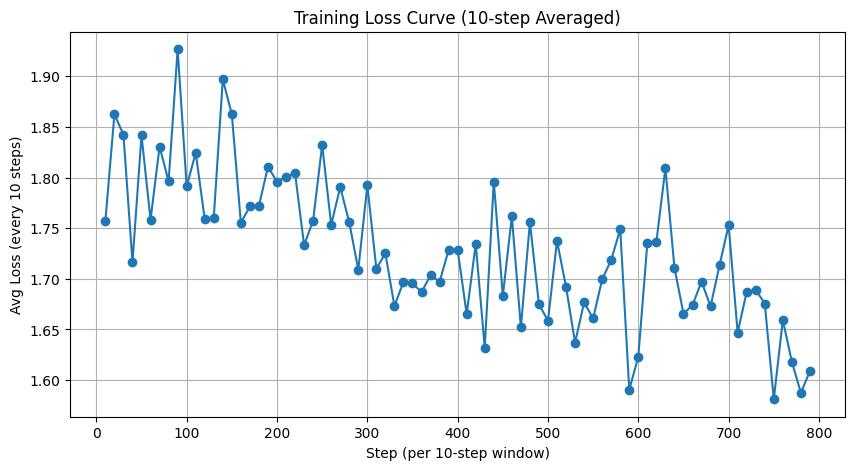

In [33]:
data = """
1.992200
2	1.622300
3	1.807000
4	1.784000
5	1.959100
6	1.829600
7	1.733200
8	1.823500
9	1.576300
10	1.866400
11	1.572300
12	1.863700
13	1.914300
14	1.669000
15	1.684700
16	1.825800
17	2.048500
18	2.146300
19	2.207300
20	1.732500
21	1.531300
22	1.810800
23	1.434400
24	1.714600
25	2.065900
26	1.599700
27	1.982500
28	1.930900
29	2.256500
30	1.670400
31	1.959700
32	1.980200
33	1.615500
34	1.522900
35	1.614300
36	1.488200
37	1.699900
38	1.996200
39	1.796500
40	1.633800
41	1.815500
42	1.645000
43	2.117700
44	1.610200
45	2.145600
46	1.646100
47	1.628900
48	1.846900
49	1.680400
50	1.982500
51	2.114400
52	1.722600
53	1.636300
54	1.964700
55	1.676800
56	1.481600
57	1.797200
58	1.998300
59	1.453900
60	1.723600
61	2.127800
62	1.755500
63	1.874700
64	1.911300
65	2.029700
66	1.593500
67	2.103200
68	1.979400
69	1.621500
70	1.788000
71	1.648500
72	1.713200
73	2.070300
74	1.976100
75	1.647800
76	1.659900
77	2.003800
78	1.692400
79	1.765300
80	1.757400
81	1.677200
82	1.886100
83	2.268600
84	1.898200
85	1.685400
86	2.026900
87	1.867100
88	1.929600
89	1.777200
90	1.747400
91	2.181500
92	1.907700
93	1.729500
94	1.660700
95	1.767000
96	1.315100
97	1.967200
98	1.772100
99	1.811400
100	1.813100
101	2.168900
102	1.817100
103	1.855200
104	1.929900
105	1.638600
106	2.168400
107	1.582800
108	1.881200
109	1.849400
110	1.770500
111	1.751800
112	1.452700
113	1.945500
114	1.817100
115	1.722000
116	1.707100
117	1.615500
118	2.185300
119	1.766300
120	1.678500
121	1.700600
122	1.901200
123	1.920300
124	1.803000
125	1.627100
126	1.607400
127	1.886300
128	1.689300
129	1.951400
130	1.568800
131	1.649800
132	2.005300
133	1.853000
134	1.801300
135	1.926600
136	1.756500
137	2.152200
138	1.723700
139	1.822000
140	1.873400
141	2.056900
142	1.573500
143	2.130500
144	1.619800
145	1.827200
146	2.048800
147	2.016000
148	1.702500
149	1.794800
150	2.104000
151	1.807200
152	1.676900
153	1.713100
154	1.825200
155	2.022500
156	1.937100
157	1.692600
158	1.693300
159	1.836900
160	1.570700
161	1.585600
162	1.808300
163	1.860200
164	1.698900
165	1.943000
166	1.835100
167	1.805100
168	1.716300
169	1.683100
170	1.722000
171	1.642900
172	1.881200
173	1.971100
174	1.809700
175	1.693600
176	1.723500
177	1.638900
178	1.435300
179	2.090300
180	1.697900
181	1.780100
182	1.933100
183	1.674100
184	2.099500
185	1.559500
186	1.767500
187	1.559900
188	2.035300
189	1.687400
190	1.862200
191	1.928500
192	1.790700
193	1.816000
194	2.019000
195	1.733400
196	1.798500
197	1.912600
198	1.769000
199	1.706100
200	1.620600
201	1.794200
202	1.743600
203	1.671300
204	1.638100
205	1.822300
206	1.980400
207	1.854000
208	1.516000
209	1.873000
210	2.058900
211	1.850400
212	2.089700
213	1.820400
214	1.885200
215	1.759200
216	2.016400
217	1.564200
218	1.357400
219	2.019100
220	1.667600
221	1.863600
222	1.674200
223	2.241400
224	1.820900
225	1.665300
226	1.419400
227	1.648000
228	1.903100
229	1.763300
230	1.517900
231	1.679000
232	1.997600
233	1.599100
234	1.716000
235	1.789700
236	1.644800
237	1.933300
238	1.635900
239	1.623500
240	1.746300
241	1.889200
242	1.913400
243	1.620200
244	1.677200
245	1.731900
246	1.986100
247	1.690300
248	1.904000
249	1.787300
250	2.047400
251	1.965800
252	1.774400
253	1.554600
254	1.638500
255	2.132600
256	1.848300
257	1.649400
258	2.049800
259	1.525100
260	1.576100
261	1.784700
262	2.152300
263	1.664400
264	1.712200
265	1.848700
266	1.559500
267	1.735400
268	1.699300
269	1.863200
270	1.964700
271	1.706600
272	1.710500
273	2.032700
274	1.714900
275	1.653200
276	1.794500
277	1.540800
278	1.684100
279	1.954700
280	1.584800
281	1.887900
282	1.628900
283	1.594200
284	1.826600
285	1.705000
286	1.667000
287	1.617800
288	1.918500
289	1.626200
290	1.560500
291	1.944900
292	1.966500
293	1.599200
294	1.850000
295	1.518200
296	2.014300
297	1.996800
298	1.989900
299	1.599600
300	1.459000
301	1.929900
302	1.854200
303	1.853000
304	1.654300
305	1.673400
306	1.527000
307	1.935600
308	1.677800
309	1.800200
310	1.510500
311	1.614000
312	1.550600
313	1.583400
314	1.677400
315	1.880400
316	1.687700
317	1.710100
318	1.702700
319	1.778400
320	1.932200
321	1.748700
322	1.785500
323	1.788800
324	1.636100
325	1.688500
326	1.835700
327	1.431000
328	1.728300
329	1.609000
330	1.662400
331	1.565600
332	1.607800
333	1.845500
334	1.668500
335	1.838200
336	1.744900
337	1.676300
338	1.480700
339	1.871100
340	1.623100
341	1.614400
342	1.828300
343	1.817600
344	1.631900
345	1.579300
346	1.558300
347	1.686100
348	1.510200
349	1.654700
350	1.871700
351	1.816100
352	1.665700
353	1.663100
354	1.734300
355	1.848000
356	1.747300
357	1.533800
358	1.512400
359	1.736900
360	1.741200
361	1.687400
362	1.822700
363	1.537100
364	1.775900
365	1.628700
366	1.910700
367	1.819500
368	1.893200
369	1.556900
370	1.588200
371	1.500700
372	1.548100
373	1.625100
374	1.701500
375	1.734300
376	1.715300
377	1.676100
378	1.842600
379	1.659900
380	1.830400
381	1.637600
382	1.798900
383	1.679500
384	1.891900
385	1.680100
386	1.945200
387	1.482700
388	1.820600
389	1.656700
390	1.313900
391	2.014700
392	1.741200
393	1.928000
394	1.756700
395	1.485100
396	1.558300
397	1.595400
398	1.788700
399	1.970300
400	1.787500
401	1.672700
402	1.677200
403	1.948300
404	1.303100
405	1.555300
406	1.532400
407	1.843200
408	1.871100
409	1.662500
410	1.747500
411	1.510700
412	1.662000
413	1.511800
414	1.643700
415	1.871700
416	1.761800
417	1.562300
418	1.669000
419	1.581900
420	2.276100
421	1.802300
422	1.616200
423	1.565400
424	1.581900
425	1.631700
426	1.702100
427	1.637200
428	1.665900
429	1.540300
430	1.674700
431	1.705700
432	1.816300
433	1.635000
434	1.705100
435	1.821700
436	1.869600
437	2.097200
438	1.795600
439	1.653600
440	1.976900
441	1.590300
442	1.922600
443	1.558500
444	1.494200
445	1.633300
446	1.667000
447	1.910900
448	1.659100
449	1.582200
450	1.826400
451	1.577700
452	1.584600
453	1.662600
454	1.793400
455	1.785200
456	1.944500
457	1.784200
458	1.852100
459	1.766400
460	1.811100
461	1.631900
462	1.829800
463	1.625100
464	1.561400
465	1.459300
466	1.662400
467	1.566500
468	1.822900
469	1.568200
470	1.654400
471	1.769900
472	1.640600
473	1.846000
474	1.681100
475	2.135700
476	1.718300
477	1.777800
478	1.486400
479	1.751100
480	1.698600
481	1.822300
482	1.721300
483	1.541600
484	1.921300
485	1.679500
486	1.729000
487	1.592300
488	1.609100
489	1.495500
490	1.941300
491	1.516700
492	1.597500
493	1.697700
494	1.720200
495	1.698100
496	1.597900
497	1.780700
498	1.501100
499	1.723800
500	1.667400
501	1.603000
502	2.047400
503	1.629000
504	1.419000
505	1.795600
506	1.874400
507	1.708400
508	1.741200
509	1.626700
510	1.835800
511	1.697000
512	1.859400
513	1.495200
514	1.510300
515	1.772000
516	1.658100
517	1.922000
518	1.704400
519	1.496300
520	1.921400
521	1.581100
522	1.632000
523	1.462300
524	1.947500
525	1.905700
526	1.235200
527	1.885000
528	1.570000
529	1.470300
530	1.632100
531	1.629600
532	1.743900
533	1.854800
534	1.579600
535	1.610300
536	1.558900
537	1.742700
538	1.583600
539	1.594900
540	1.536300
541	1.961800
542	1.692700
543	1.839800
544	1.483200
545	1.731000
546	1.787800
547	1.547000
548	1.559300
549	1.555600
550	1.741800
551	1.670200
552	1.591900
553	1.556800
554	1.773000
555	1.682500
556	1.808400
557	1.911500
558	1.666300
559	1.546000
560	1.434300
561	2.024400
562	1.874300
563	1.976000
564	1.486100
565	1.598400
566	1.713100
567	1.750200
568	1.952600
569	1.541300
570	1.588000
571	1.706600
572	1.807300
573	1.936200
574	1.622900
575	1.772200
576	1.929400
577	1.743900
578	1.717500
579	1.714600
580	1.708400
581	1.537500
582	1.646900
583	1.621600
584	1.685400
585	1.620700
586	1.325600
587	1.378500
588	1.728300
589	1.289600
590	1.789400
591	1.819900
592	1.824300
593	1.663000
594	1.462800
595	1.645000
596	1.687200
597	1.702400
598	1.691200
599	1.457300
600	1.681800
601	1.415800
602	1.603200
603	1.484500
604	1.866800
605	1.863300
606	1.798800
607	1.529900
608	1.953400
609	1.750100
610	1.672600
611	1.830200
612	1.748800
613	1.891200
614	1.873800
615	1.830900
616	1.431800
617	1.789200
618	1.839200
619	1.636500
620	1.381800
621	1.941300
622	1.499000
623	1.574300
624	1.890500
625	1.865800
626	1.547300
627	1.903800
628	2.091600
629	2.030000
630	1.712000
631	1.978700
632	1.727400
633	2.003900
634	1.891900
635	1.543300
636	1.667800
637	1.634100
638	1.780500
639	1.605400
640	1.739500
641	1.516700
642	1.701200
643	1.754400
644	1.704600
645	1.501300
646	1.678500
647	1.549400
648	1.574700
649	1.835300
650	1.821400
651	1.535400
652	1.633700
653	1.780200
654	1.601800
655	1.582000
656	1.619100
657	1.772700
658	1.409400
659	1.641200
660	1.857700
661	1.842200
662	1.651500
663	1.586400
664	1.654300
665	1.447700
666	1.767800
667	1.874700
668	1.675800
669	1.692500
670	1.579100
671	2.043200
672	1.628100
673	1.662700
674	1.452100
675	1.749300
676	1.601900
677	2.054900
678	1.782200
679	1.519300
680	1.627900
681	1.649700
682	1.841100
683	1.833900
684	1.548800
685	1.612900
686	1.770300
687	1.671400
688	1.581000
689	1.679800
690	1.767200
691	1.830600
692	1.906100
693	1.793500
694	1.718400
695	1.767100
696	1.839300
697	1.695400
698	1.824700
699	1.606000
700	1.625300
701	1.753400
702	1.465400
703	1.759000
704	1.466500
705	1.639200
706	1.761100
707	1.558400
708	1.611000
709	1.763600
710	1.697000
711	1.746500
712	1.687000
713	1.731600
714	1.573600
715	1.363300
716	1.889600
717	1.850900
718	1.550500
719	1.625500
720	1.758300
721	1.842000
722	1.706700
723	1.646000
724	1.966000
725	1.679900
726	1.525500
727	1.752000
728	1.629500
729	1.758000
730	1.674400
731	1.553000
732	1.486200
733	1.789500
734	1.792100
735	1.583700
736	1.485700
737	1.582700
738	1.584000
739	1.858500
740	1.709000
741	1.884800
742	1.439100
743	1.261800
744	1.667900
745	1.639600
746	1.324300
747	1.557400
748	1.617600
749	1.776400
750	1.767500
751	1.759200
752	1.937200
753	1.647400
754	1.418700
755	1.655300
756	1.623800
757	1.572300
758	1.435900
759	1.711700
760	1.964300
761	1.626900
762	1.714800
763	1.427900
764	1.484300
765	1.589500
766	1.582200
767	1.555300
768	1.264200
769	1.878300
770	1.945300
771	1.738400
772	1.682300
773	1.848600
774	1.674700
775	1.632000
776	1.495700
777	1.655100
778	1.399500
779	1.502300
780	1.447500
781	1.536300
782	1.507000
783	1.807100
784	1.614200
785	1.242600
786	1.578800
787	1.616900
788	1.526300
789	1.500000
790	1.768200
791	1.927600
792	1.694800
793	1.642000
794	1.375700
795	1.667000
796	1.714100
797	1.584400
798	1.524200
799	1.770000
800	1.432900
801	1.652300
802	1.493700
803	1.776300


"""
import matplotlib.pyplot as plt

steps = []
losses = []

# parse data
for line in data.strip().split("\n"):
    parts = line.split()
    if len(parts) == 2:
        step, loss = parts
        steps.append(int(step))
        losses.append(float(loss))

# ---- compute 10-step average ----
window = 10
avg_steps = []
avg_losses = []

for i in range(0, len(losses), window):
    chunk = losses[i:i+window]
    if len(chunk) == window:  # ensure full window
        avg_losses.append(sum(chunk) / window)
        avg_steps.append(i + window)  # or use i+window//2 or just index

# ---- Plot ----
plt.figure(figsize=(10, 5))
plt.plot(avg_steps, avg_losses, marker='o')
plt.xlabel("Step (per 10-step window)")
plt.ylabel("Avg Loss (every 10 steps)")
plt.title("Training Loss Curve (10-step Averaged)")
plt.grid(True)

plt.show()




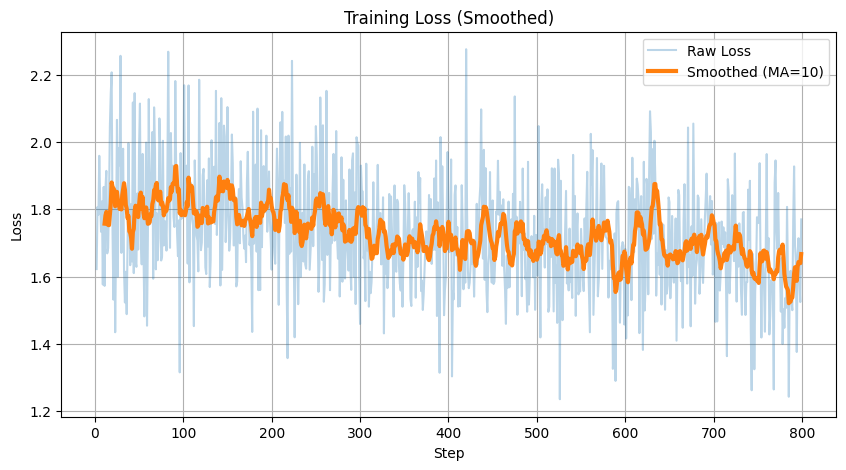

In [32]:
import numpy as np
window = 10
loss_smooth = np.convolve(losses, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(steps, losses, alpha=0.3, label='Raw Loss')
plt.plot(steps[window-1:], loss_smooth, linewidth=3, label='Smoothed (MA=10)')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
1	2.001500
10	1.789100
20	1.878900
30	1.810600
40	1.740800
50	1.823100
60	1.768000
70	1.891400
80	1.806200
90	1.890700
100	1.806300
110	1.881300
120	1.780300
130	1.781600
140	1.876100
150	1.906000
160	1.797300
170	1.784000
180	1.779200
190	1.817600
200	1.832600
210	1.815600
220	1.824700
230	1.774700
240	1.758000
250	1.847800
260	1.795000
270	1.821300
280	1.760600
290	1.724100
300	1.817400
310	1.765800
320	1.734500
330	1.712300
340	1.712900
350	1.696400
360	1.720400
370	1.742200
380	1.703500
390	1.710800
400	1.782200
410	1.697700
420	1.720800
430	1.657500
440	1.821100
450	1.696700
460	1.769600
470	1.649700
480	1.760200
490	1.713400
500	1.657300
510	1.732900
520	1.707300
530	1.633500
540	1.643300
550	1.688400
560	1.660300
570	1.744700
580	1.757200
590	1.551800
600	1.651300
610	1.679700
620	1.706700
630	1.784000
640	1.733700
650	1.636100
660	1.616000
670	1.642700
680	1.680800
690	1.660300
700	1.720200
710	1.606700
720	1.632500
730	1.670900
740	1.593500
750	1.548600
760	1.622900
770	1.558600
780	1.554300
790	1.517000
800	1.572300
810	1.534400
820	1.539000
830	1.582400
840	1.567200
850	1.547800
860	1.507200
870	1.563100
880	1.627800
890	1.532100
900	1.704100
910	1.666600
920	1.526000
930	1.593800
940	1.574400
950	1.623700
960	1.642400
970	1.480100
980	1.544900
990	1.512500
1000	1.520300
